In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib

In [7]:
# Pandas ayarları (Tüm sütunları görebilmek için)
pd.set_option('display.max_columns', None)

# Temizlenmiş veriyi oku
# low_memory=False ve dtype optimizasyonu büyük dosyalarda hız kazandırır
print("Veri okunuyor...")
df = pd.read_csv('../data/final_processed_data.csv', low_memory=False)

print(f"Veri yüklendi! Boyut: {df.shape}")

Veri okunuyor...
Veri yüklendi! Boyut: (1345310, 125)


In [8]:
# Target sütunu "loan_status"tan türetmiştik (1: Batık, 0: Ödenmiş)
# Eğer temizlik aşamasında adını 'target' yaptıysan öyle kullan, yoksa kontrol et.
# Biz önceki adımlarda 'target' ismini vermiştik.

X=df.drop('target', axis=1)
y= df['target']

# RAM tasarrufu ve Hız testi için verinin %20'sini kullanarak bir "Prototype Model" kuralım.
# İşler yolunda giderse sonra tüm veriyi (%100) kullanırız.
# stratify=y -> Hedef değişkenin oranını (Ödeyen/Batıran) bozmadan örneklem alır.
X_train, X_test, y_train, y_test = train_test_split (X,y,train_size=0.2, random_state=42, stratify=y)

print(f"Eğitim Seti: {X_train.shape}")
print(f"Test Seti:   {X_test.shape}")

Eğitim Seti: (269062, 124)
Test Seti:   (1076248, 124)


In [9]:
# Verileri standartlaştırma (0 ortalama, 1 varyans)
# Bu adım Lojistik Regresyon için ZORUNLUDUR, yoksa model saçmalar.
scaler =StandardScaler()

print("Veriler ölçekleniyor...")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Model eğitiliyor...")
lr= LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
print("✅ Eğitim Tamamlandı!")

Veriler ölçekleniyor...
Model eğitiliyor...
✅ Eğitim Tamamlandı!



--- Model Performans Raporu ---
              precision    recall  f1-score   support

           0       0.94      0.95      0.95    861401
           1       0.80      0.75      0.78    214847

    accuracy                           0.91   1076248
   macro avg       0.87      0.85      0.86   1076248
weighted avg       0.91      0.91      0.91   1076248



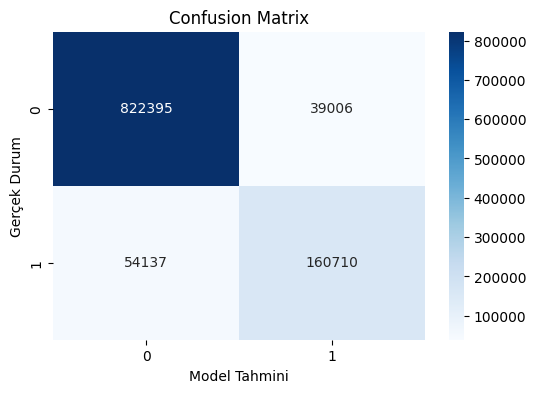

In [12]:
# Tahmin yap
y_pred = lr.predict(X_test_scaled)

# Sonuçları yazdır
print("\n--- Model Performans Raporu ---")
print(classification_report(y_test, y_pred))

# Karışıklık Matrisi (Hata nerede?)
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Gerçek Durum")
plt.xlabel("Model Tahmini")
plt.show()

✅ Random Forest Eğitimi Tamamlandı!
Test ediliyor...

--- Random Forest Sonuçları ---
              precision    recall  f1-score   support

           0       0.94      0.95      0.95    861401
           1       0.80      0.76      0.78    214847

    accuracy                           0.91   1076248
   macro avg       0.87      0.86      0.86   1076248
weighted avg       0.91      0.91      0.91   1076248



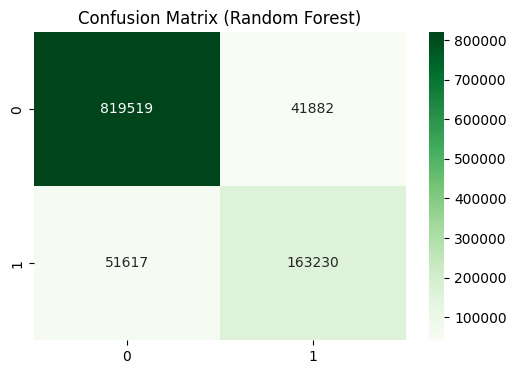

In [14]:
# Random Forest Modeli Kuruyoruz
# n_estimators=100: 100 tane ağaç dik.
# class_weight='balanced': Dengesizliği çöz (Batıklara daha çok önem ver).
# n_jobs=-1: Bilgisayarın tüm işlemci çekirdeklerini kullan (Hız için).

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=1)
rf.fit(X_train_scaled, y_train)

print("✅ Random Forest Eğitimi Tamamlandı!")

print("Test ediliyor...")
y_pred_rf = rf.predict(X_test_scaled)

print("\n--- Random Forest Sonuçları ---")
print(classification_report(y_test, y_pred_rf))

# Yeni Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (Random Forest)")
plt.show()

C:\Users\Erdem\AppData\Local\Temp\ipykernel_50456\1777117167.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


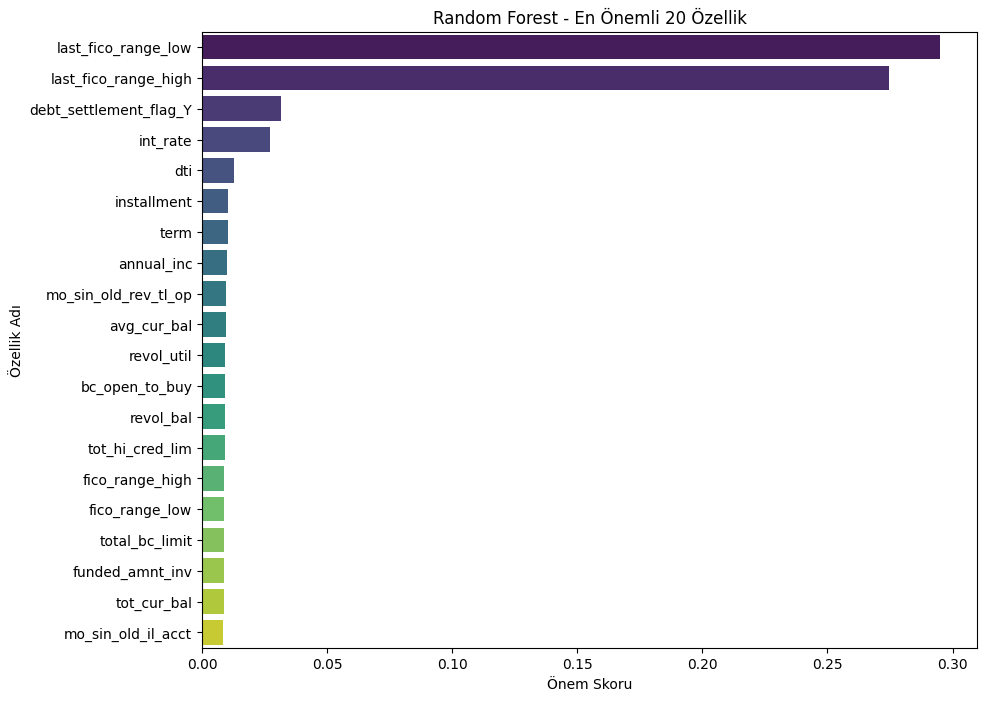

In [15]:
# Modelin içinden önem skorlarını çekiyoruz
importances = rf.feature_importances_
feature_names = X_train.columns

# Okunabilir bir tablo yapalım
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(20)

# Görselleştirelim
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title("Random Forest - En Önemli 20 Özellik")
plt.xlabel("Önem Skoru")
plt.ylabel("Özellik Adı")
plt.show()

In [18]:
# 1. Modeli Kaydet
print("En iyi model kaydediliyor...")
joblib.dump(rf, '../models/credit_risk_rf_model.pkl')

# 2. Scaler'ı da kaydetmek ZORUNDAYIZ!
# (Çünkü yeni gelen veriyi de aynı şekilde ölçeklendirmemiz lazım)
joblib.dump(scaler, '../models/scaler.pkl')

print("✅ Model ve Scaler başarıyla 'models' klasörüne kaydedildi!")

En iyi model kaydediliyor...
✅ Model ve Scaler başarıyla 'models' klasörüne kaydedildi!
